A notebook to check on the rotated test_datasets

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os

%matplotlib inline

# Plan
Evaluate error in U,V, bearing and speed for each of the following test datasets
* GIOPS
* RIOPS user grid
* RIOPS native grid

Each dataset has cases which represent Eastward velocity, Northward velocity and North-eastward velocity.


## Procedure for test datasets creation
The angle ($\alpha$) between model gridlines and East was calculated for each dataset. Once the angle is determined, the east/north velocities $(v_{east}, v_{north})$ are simply:

$ v_{east} = v_x * cos(\alpha) - v_y *sin(\alpha)$  
$ v_{north} = v_x * sin(\alpha) + v_y * cos(\alpha)$ 

where $(v_x, v_y)$ are the velocities along the x gridlines and y gridlines

* GIOPS test datasets were interpolated from latlon grid to ORCA grid using [SOSIE](https://github.com/brodeau/sosie) to give x/y velocities. The east/north velocities were calculated as described above.
* RIOPS native test datasets were interpolated from latlon grid to RIOPS native grid using [SOSIE](https://github.com/brodeau/sosie) to give x/y velocities. The east/north velocities were calculated as described above.
* RIOPS user test datasets were interpolated from latlon grid to RIOPS user using a formula for translating vectors in polar sterographic coordinates. The east/north velocities were calculated as described above.

NOTE: The use of SOSIE requires mesh_mask.nc files containing coordinates on U,V,T,F grids.

## Creation of grid angle
The grid angle was calculated in several ways:
* For datasets with a mesh_mask.nc file available, grid angles were calulated in a manner simlar to SOSIE, but excluding the SOSIE treatment of the north fold. This includes GIOPS and RIOPS native. There is a potential source of error since the northfold is not handled correctly.
* For RIOPS user, the angle was determined by calculating the angle between x gridlines and north in polar stereographic coordinates, and then translated to an angle wrt east. This is similar to the Sosie calculation, but Sosie has coordinate information about the U,V,T and F grid, whereas we only have informaiton on the T-grid. 
* For other datasets (e.g SalishSea, Glorys, not presented) the angle was determined by calculating a bearing between adjacent  x gridpoints. I find this method is less accurate than the method above, especially near the north pole and am considering removing this method and only using method above in absence for grid files.

# Functions

In [2]:
def print_mean_min_max_error(var, var_name, var_units, nominal_value):
    diff = nominal_value - var
    print('{} mean error: {} {}'.format(var_name, np.nanmean(diff), var_units))
    print('{} max error: {} {}'.format(var_name, np.nanmax(diff), var_units))
    print('{} min error: {} {}'.format(var_name, np.nanmin(diff), var_units))

In [3]:
def calculate_bearing(u, v):
    bearing = np.arctan2(v,u)
    bearing = np.pi / 2.0 - bearing
    bearing[bearing > np.pi] -= 2 * np.pi
    bearing *= 180.0 / np.pi
    return bearing

In [4]:
def plot_variable(var, var_name, var_units, nominal_value, case, diff_limit=0.1,
                 xlim=[0,1000], ylim=[0,1000]):
    fig,axs = plt.subplots(1,2,figsize=(15,2))
    ax=axs[0]
    mesh=ax.pcolormesh(var,vmin=nominal_value-diff_limit,vmax=nominal_value+diff_limit)
    ax.set_title('{}: Case {}'.format(var_name, case))
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('{} [{}]'.format(var_name, var_units))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax=axs[1]
    mesh=ax.pcolormesh(nominal_value-var,vmin=-diff_limit,vmax=diff_limit,cmap='seismic')
    ax.set_title('Error in {}: Case {}'.format(var_name, case))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('{} [{}]'.format(var_name, var_units))
    return fig

In [5]:
cases={'east': {'U': 3, 'V': 0, 'theta': 90, 'speed': 3},
       'north': {'U': 0, 'V': 3, 'theta': 0, 'speed': 3},
       'north_east': {'U': 3, 'V': 3, 'theta': 45, 'speed': np.sqrt(3**2 + 3**2)}}

# GIOPS

In [6]:
file='latlon-giops_native_grid_T_surface_cardinal_velocity.nc'
basdir='/data/hdd/test_datasets/giops/daily/'
us={}
vs={}
lons={}
lats={}
thetas={}
speeds={}
for case in cases:
    f=nc.Dataset(os.path.join(basdir,case,'rotated',file))
    us[case] = f.variables['east_vel'][0,0,:]
    vs[case] = f.variables['north_vel'][0,0,:]
    lons[case] = f.variables['nav_lon'][:]
    lats[case] = f.variables['nav_lat'][:]
    thetas[case] = calculate_bearing(us[case],vs[case])
    speeds[case] = np.sqrt(np.square(us[case]) + np.square(vs[case]))

/home/nsoontiens/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in square


## East

Evaluating error for Case east
Error for U
U mean error: -1.4721819319163387e-09 m/s
U max error: 4.76837158203125e-07 m/s
U min error: -4.76837158203125e-07 m/s
Error for V
V mean error: 1.532911908519452e-09 m/s
V max error: 0.00011184811592102051 m/s
V min error: -3.5762786865234375e-07 m/s
Error for theta
theta mean error: -3.802200509994691e-08 deg CW N
theta max error: 7.62939453125e-06 deg CW N
theta min error: -0.00214385986328125 deg CW N
Error for speed
speed mean error: -1.4721819319163387e-09 m/s
speed max error: 4.76837158203125e-07 m/s
speed min error: -4.76837158203125e-07 m/s


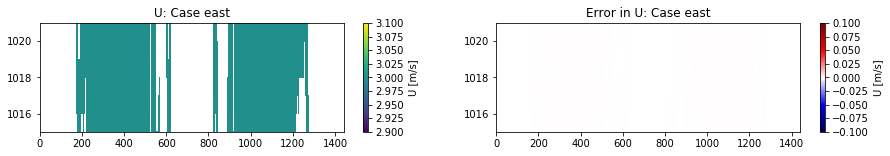

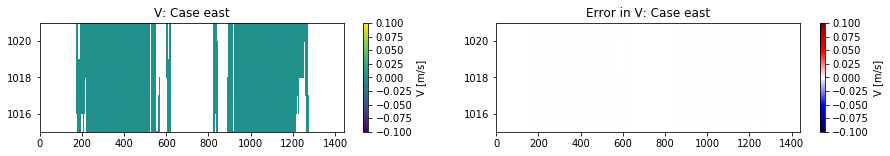

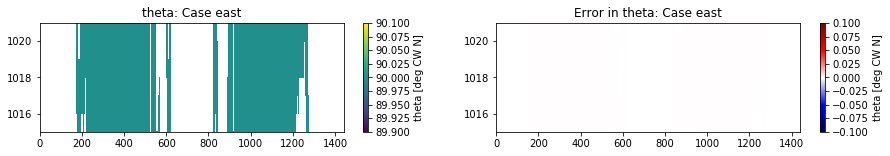

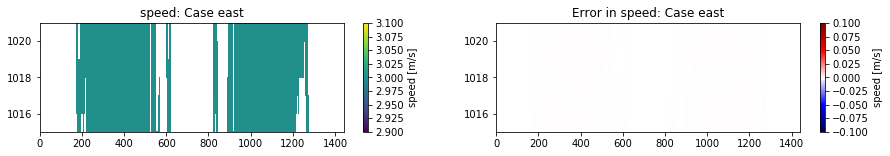

In [7]:
var_names=['U', 'V', 'theta', 'speed']
var_dicts = [us, vs, thetas, speeds]
varunits = ['m/s', 'm/s', 'deg CW N', 'm/s']
case='east'
xlim=[0,us[case].shape[-1]]
ylim=[1015,us[case].shape[0]]
print('Evaluating error for Case {}'.format(case))
for var_name, var_dict, var_unit in zip(var_names, var_dicts, varunits):
    print('Error for {}'.format(var_name))
    var=var_dict[case]
    nominal_value=cases[case][var_name]
    print_mean_min_max_error(var, var_name, var_unit, nominal_value)
    plot_variable(var, var_name, var_unit, nominal_value, case,xlim=xlim,ylim=ylim)

## North

Evaluating error for Case north
Error for U
U mean error: -1.532911908519452e-09 m/s
U max error: 3.5762786865234375e-07 m/s
U min error: -0.00011184811592102051 m/s
Error for V
V mean error: -1.4721819319163387e-09 m/s
V max error: 4.76837158203125e-07 m/s
V min error: -4.76837158203125e-07 m/s
Error for theta
theta mean error: -4.937855919706635e-07 deg CW N
theta max error: 0.0 deg CW N
theta min error: -0.0021378491073846817 deg CW N
Error for speed
speed mean error: -1.4721819319163387e-09 m/s
speed max error: 4.76837158203125e-07 m/s
speed min error: -4.76837158203125e-07 m/s


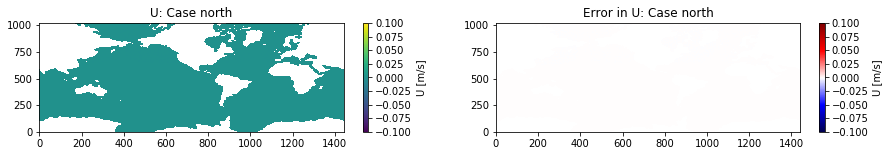

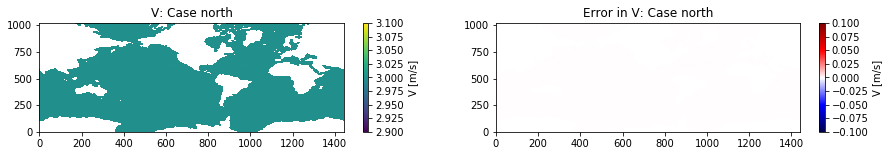

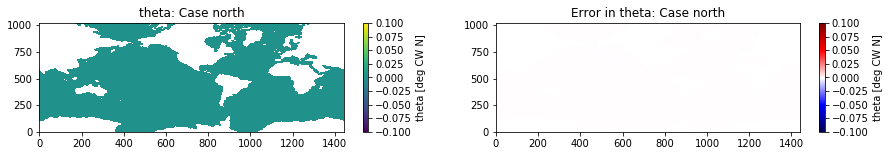

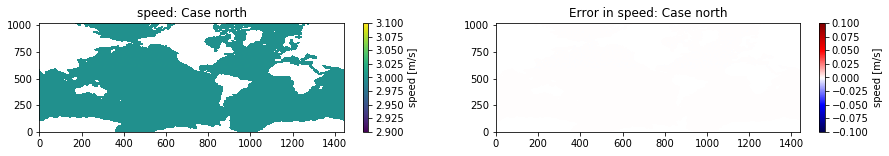

In [8]:
var_names=['U', 'V', 'theta', 'speed']
var_dicts = [us, vs, thetas, speeds]
varunits = ['m/s', 'm/s', 'deg CW N', 'm/s']
case='north'
xlim=[0,us[case].shape[-1]]
ylim=[0,us[case].shape[0]]
print('Evaluating error for Case {}'.format(case))
for var_name, var_dict, var_unit in zip(var_names, var_dicts, varunits):
    print('Error for {}'.format(var_name))
    var=var_dict[case]
    nominal_value=cases[case][var_name]
    print_mean_min_max_error(var, var_name, var_unit, nominal_value)
    plot_variable(var, var_name, var_unit, nominal_value, case,xlim=xlim,ylim=ylim)

## North east

Evaluating error for Case north_east
Error for U
U mean error: -1.5499704852928176e-09 m/s
U max error: 4.76837158203125e-07 m/s
U min error: -0.00011181831359863281 m/s
Error for V
V mean error: 1.5581448353785277e-09 m/s
V max error: 0.00011181831359863281 m/s
V min error: -4.76837158203125e-07 m/s
Error for theta
theta mean error: -3.577325458081759e-08 deg CW N
theta max error: 3.814697265625e-06 deg CW N
theta min error: -0.002140045166015625 deg CW N
Error for speed
speed mean error: -2.7929528911840862e-08 m/s
speed max error: 4.76837158203125e-07 m/s
speed min error: -9.5367431640625e-07 m/s


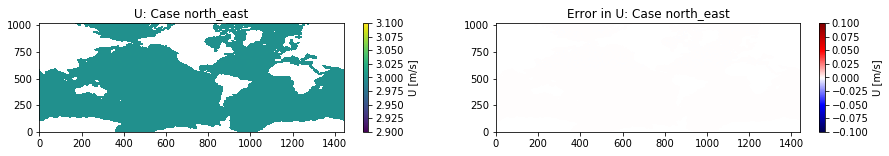

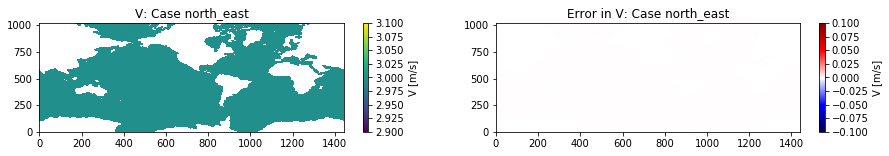

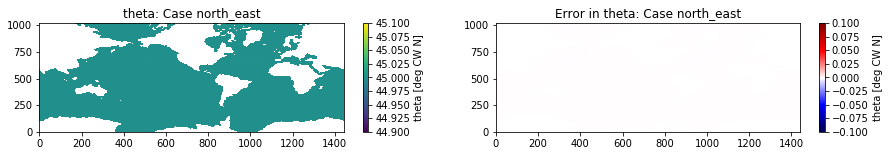

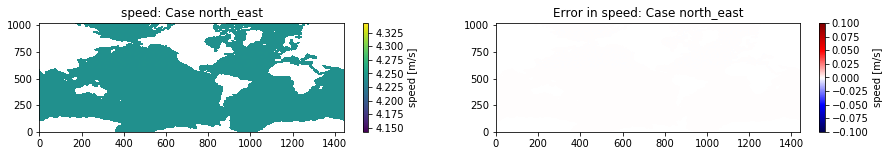

In [9]:
var_names=['U', 'V', 'theta', 'speed']
var_dicts = [us, vs, thetas, speeds]
varunits = ['m/s', 'm/s', 'deg CW N', 'm/s']
case='north_east'
xlim=[0,us[case].shape[-1]]
ylim=[0,us[case].shape[0]]
print('Evaluating error for Case {}'.format(case))
for var_name, var_dict, var_unit in zip(var_names, var_dicts, varunits):
    print('Error for {}'.format(var_name))
    var=var_dict[case]
    nominal_value=cases[case][var_name]
    print_mean_min_max_error(var, var_name, var_unit, nominal_value)
    plot_variable(var, var_name, var_unit, nominal_value, case,xlim=xlim,ylim=ylim)

# RIOPS Native

In [10]:
file='latlon-riops_native_grid_T_surface_cardinal_velocity.nc'
basdir='/data/hdd/test_datasets/riops/riopsf/native/'
us={}
vs={}
lons={}
lats={}
thetas={}
speeds={}
for case in cases:
    f=nc.Dataset(os.path.join(basdir,case,'rotated',file))
    us[case] = f.variables['east_vel'][0,0,:]
    vs[case] = f.variables['north_vel'][0,0,:]
    lons[case] = f.variables['nav_lon'][:]
    lats[case] = f.variables['nav_lat'][:]
    thetas[case] = calculate_bearing(us[case],vs[case])
    speeds[case] = np.sqrt(np.square(us[case]) + np.square(vs[case]))

/home/nsoontiens/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in square


## East

Evaluating error for Case east
Error for U
U mean error: -3.5164942069343397e-09 m/s
U max error: 4.76837158203125e-07 m/s
U min error: -4.76837158203125e-07 m/s
Error for V
V mean error: 6.001442454106609e-09 m/s
V max error: 0.00023287534713745117 m/s
V min error: -3.5762786865234375e-07 m/s
Error for theta
theta mean error: -1.4575634565971995e-07 deg CW N
theta max error: 7.62939453125e-06 deg CW N
theta min error: -0.00444793701171875 deg CW N
Error for speed
speed mean error: -3.5164942069343397e-09 m/s
speed max error: 4.76837158203125e-07 m/s
speed min error: -4.76837158203125e-07 m/s


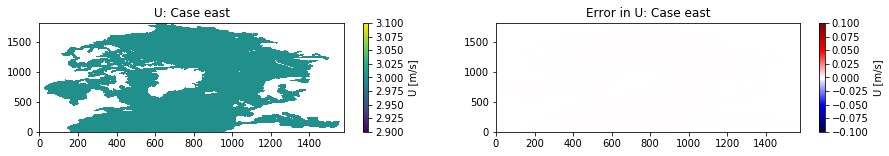

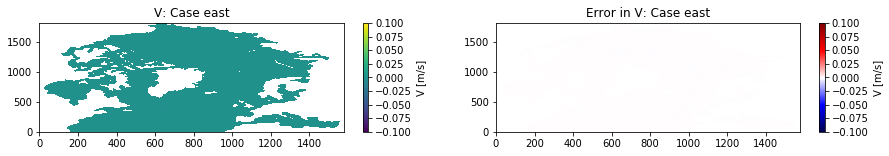

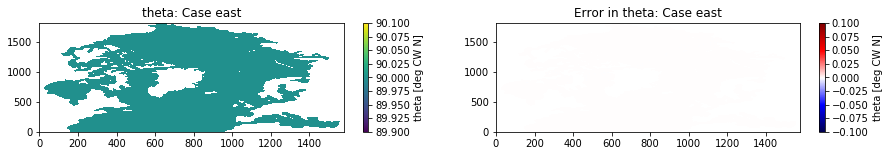

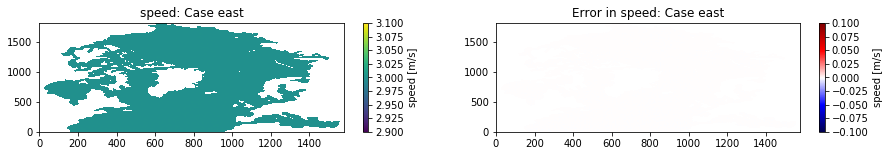

In [11]:
var_names=['U', 'V', 'theta', 'speed']
var_dicts = [us, vs, thetas, speeds]
varunits = ['m/s', 'm/s', 'deg CW N', 'm/s']
case='east'
xlim=[0,us[case].shape[-1]]
ylim=[0,us[case].shape[0]]
print('Evaluating error for Case {}'.format(case))
for var_name, var_dict, var_unit in zip(var_names, var_dicts, varunits):
    print('Error for {}'.format(var_name))
    var=var_dict[case]
    nominal_value=cases[case][var_name]
    print_mean_min_max_error(var, var_name, var_unit, nominal_value)
    plot_variable(var, var_name, var_unit, nominal_value, case,xlim=xlim,ylim=ylim)

# North

Evaluating error for Case north
Error for U
U mean error: -6.001442454106609e-09 m/s
U max error: 3.5762786865234375e-07 m/s
U min error: -0.00023287534713745117 m/s
Error for V
V mean error: -3.5164942069343397e-09 m/s
V max error: 4.76837158203125e-07 m/s
V min error: -4.76837158203125e-07 m/s
Error for theta
theta mean error: -1.7284884279433754e-06 deg CW N
theta max error: 0.0 deg CW N
theta min error: -0.00445328326895833 deg CW N
Error for speed
speed mean error: -3.5164942069343397e-09 m/s
speed max error: 4.76837158203125e-07 m/s
speed min error: -4.76837158203125e-07 m/s


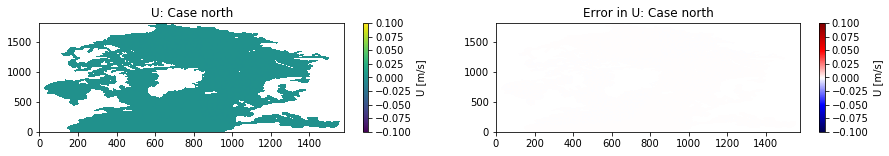

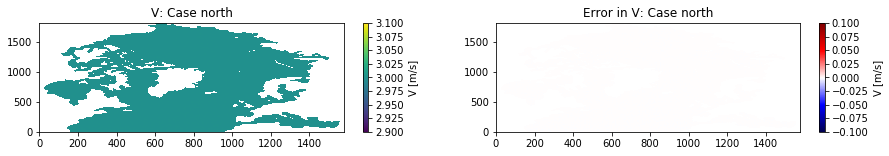

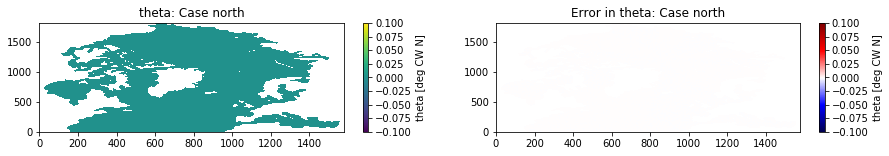

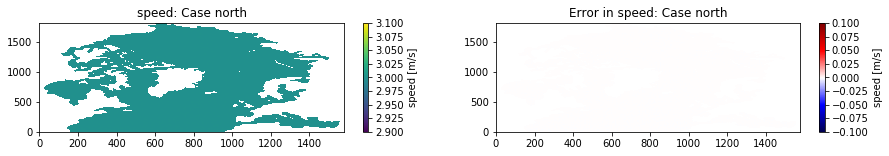

In [12]:
var_names=['U', 'V', 'theta', 'speed']
var_dicts = [us, vs, thetas, speeds]
varunits = ['m/s', 'm/s', 'deg CW N', 'm/s']
case='north'
xlim=[0,us[case].shape[-1]]
ylim=[0,us[case].shape[0]]
print('Evaluating error for Case {}'.format(case))
for var_name, var_dict, var_unit in zip(var_names, var_dicts, varunits):
    print('Error for {}'.format(var_name))
    var=var_dict[case]
    nominal_value=cases[case][var_name]
    print_mean_min_max_error(var, var_name, var_unit, nominal_value)
    plot_variable(var, var_name, var_unit, nominal_value, case,xlim=xlim,ylim=ylim)

## North East

Evaluating error for Case north_east
Error for U
U mean error: -6.311695166516529e-09 m/s
U max error: 4.76837158203125e-07 m/s
U min error: -0.00023293495178222656 m/s
Error for V
V mean error: 5.3724078519223895e-09 m/s
V max error: 0.00023293495178222656 m/s
V min error: -4.76837158203125e-07 m/s
Error for theta
theta mean error: -1.2345967093096988e-07 deg CW N
theta max error: 3.814697265625e-06 deg CW N
theta min error: -0.004451751708984375 deg CW N
Error for speed
speed mean error: -1.0128950833632189e-07 m/s
speed max error: 4.76837158203125e-07 m/s
speed min error: -9.5367431640625e-07 m/s


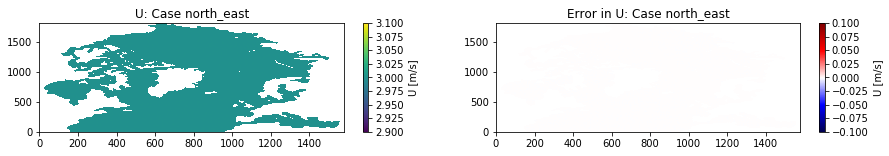

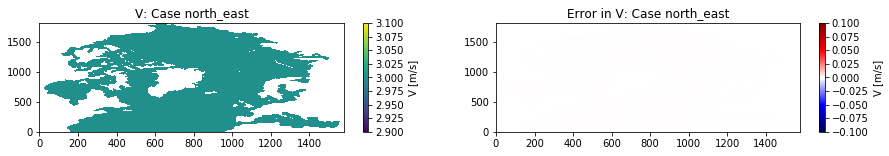

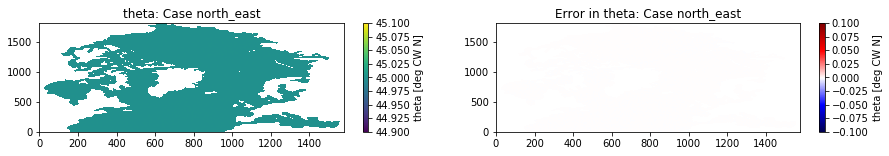

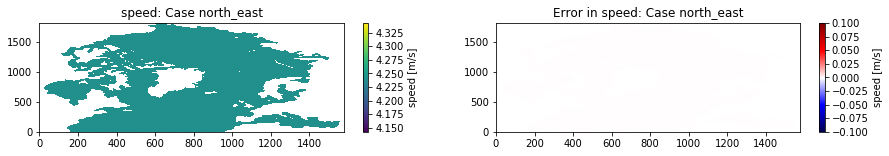

In [13]:
var_names=['U', 'V', 'theta', 'speed']
var_dicts = [us, vs, thetas, speeds]
varunits = ['m/s', 'm/s', 'deg CW N', 'm/s']
case='north_east'
xlim=[0,us[case].shape[-1]]
ylim=[0,us[case].shape[0]]
print('Evaluating error for Case {}'.format(case))
for var_name, var_dict, var_unit in zip(var_names, var_dicts, varunits):
    print('Error for {}'.format(var_name))
    var=var_dict[case]
    nominal_value=cases[case][var_name]
    print_mean_min_max_error(var, var_name, var_unit, nominal_value)
    plot_variable(var, var_name, var_unit, nominal_value, case,xlim=xlim,ylim=ylim)

# RIOPS user

In [14]:
file='2018010100_003_2D_nps_cardinal_velocity.nc'
basdir='/data/hdd/test_datasets/riops/riopsf/user/'
us={}
vs={}
lons={}
lats={}
thetas={}
speeds={}
for case in cases:
    f=nc.Dataset(os.path.join(basdir,case,'rotated',file))
    us[case] = f.variables['east_vel'][0,0,:]
    vs[case] = f.variables['north_vel'][0,0,:]
    lons[case] = f.variables['longitude'][:]
    lats[case] = f.variables['latitude'][:]
    thetas[case] = calculate_bearing(us[case],vs[case])
    speeds[case] = np.sqrt(np.square(us[case]) + np.square(vs[case]))

/home/nsoontiens/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in square


## East

Evaluating error for Case east
Error for U
U mean error: 2.085484140934568e-07 m/s
U max error: 0.003642559051513672 m/s
U min error: -4.76837158203125e-07 m/s
Error for V
V mean error: -4.127731756398134e-07 m/s
V max error: 0.14779269695281982 m/s
V min error: -0.1365167498588562 m/s
Error for theta
theta mean error: 5.3810067583981436e-06 deg CW N
theta max error: 2.6081771850585938 deg CW N
theta min error: -2.8237838745117188 deg CW N
Error for speed
speed mean error: -9.887395790997289e-09 m/s
speed max error: 4.76837158203125e-07 m/s
speed min error: -4.76837158203125e-07 m/s


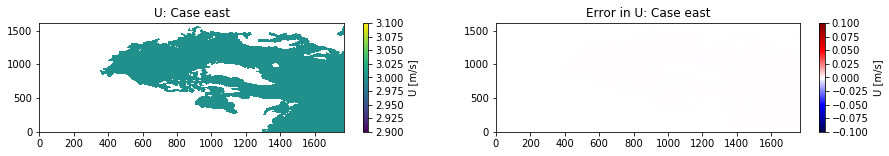

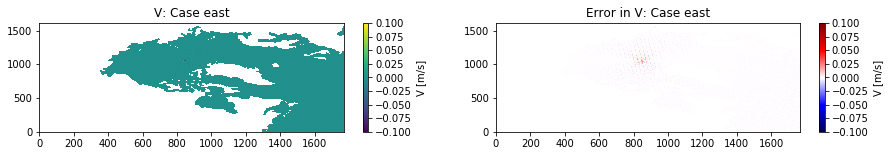

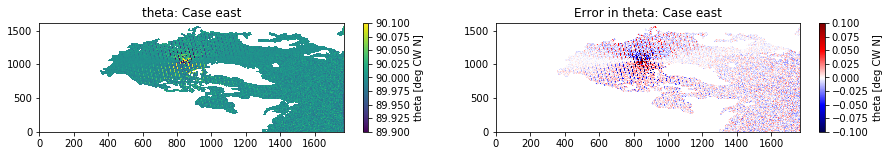

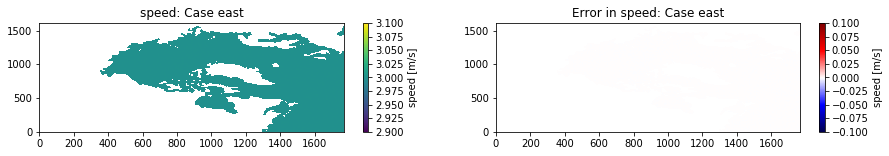

In [15]:
var_names=['U', 'V', 'theta', 'speed']
var_dicts = [us, vs, thetas, speeds]
varunits = ['m/s', 'm/s', 'deg CW N', 'm/s']
case='east'
xlim=[0,us[case].shape[-1]]
ylim=[0,us[case].shape[0]]
print('Evaluating error for Case {}'.format(case))
for var_name, var_dict, var_unit in zip(var_names, var_dicts, varunits):
    print('Error for {}'.format(var_name))
    var=var_dict[case]
    nominal_value=cases[case][var_name]
    print_mean_min_max_error(var, var_name, var_unit, nominal_value)
    plot_variable(var, var_name, var_unit, nominal_value, case,xlim=xlim,ylim=ylim)

## North

Evaluating error for Case north
Error for U
U mean error: 4.127731756398134e-07 m/s
U max error: 0.1365167498588562 m/s
U min error: -0.14779269695281982 m/s
Error for V
V mean error: 2.085484140934568e-07 m/s
V max error: 0.003642559051513672 m/s
V min error: -4.76837158203125e-07 m/s
Error for theta
theta mean error: 4.472177351999562e-06 deg CW N
theta max error: 2.6081759929656982 deg CW N
theta min error: -2.823777675628662 deg CW N
Error for speed
speed mean error: -9.887395790997289e-09 m/s
speed max error: 4.76837158203125e-07 m/s
speed min error: -4.76837158203125e-07 m/s


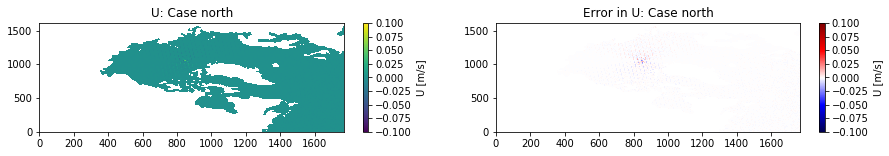

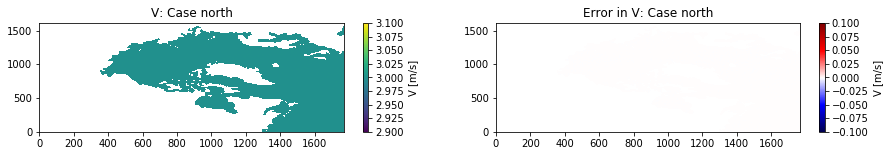

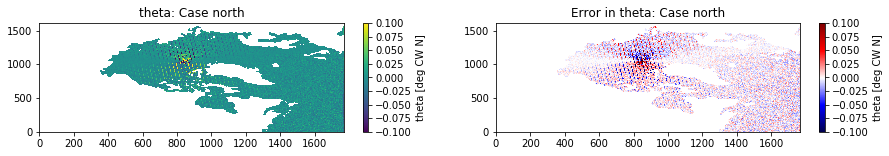

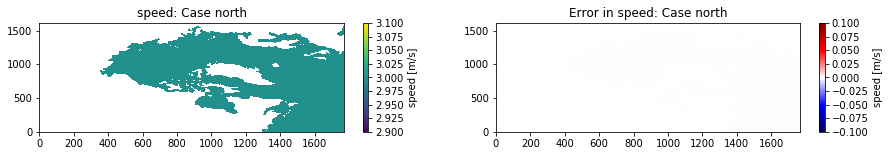

In [16]:
var_names=['U', 'V', 'theta', 'speed']
var_dicts = [us, vs, thetas, speeds]
varunits = ['m/s', 'm/s', 'deg CW N', 'm/s']
case='north'
xlim=[0,us[case].shape[-1]]
ylim=[0,us[case].shape[0]]
print('Evaluating error for Case {}'.format(case))
for var_name, var_dict, var_unit in zip(var_names, var_dicts, varunits):
    print('Error for {}'.format(var_name))
    var=var_dict[case]
    nominal_value=cases[case][var_name]
    print_mean_min_max_error(var, var_name, var_unit, nominal_value)
    plot_variable(var, var_name, var_unit, nominal_value, case,xlim=xlim,ylim=ylim)

# North East

Evaluating error for Case north_east
Error for U
U mean error: 6.274732413658057e-07 m/s
U max error: 0.13962435722351074 m/s
U min error: -0.1441500186920166 m/s
Error for V
V mean error: -1.9849308330321946e-07 m/s
V max error: 0.15143537521362305 m/s
V min error: -0.1334090232849121 m/s
Error for theta
theta mean error: 5.528293058887357e-06 deg CW N
theta max error: 2.6081771850585938 deg CW N
theta min error: -2.823780059814453 deg CW N
Error for speed
speed mean error: -8.598986767083261e-08 m/s
speed max error: 4.76837158203125e-07 m/s
speed min error: -9.5367431640625e-07 m/s


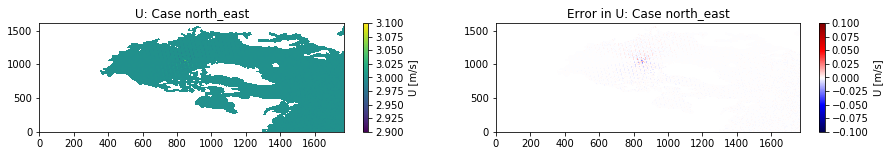

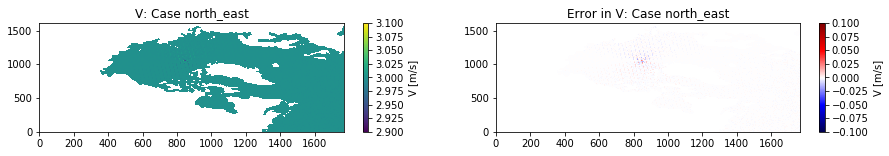

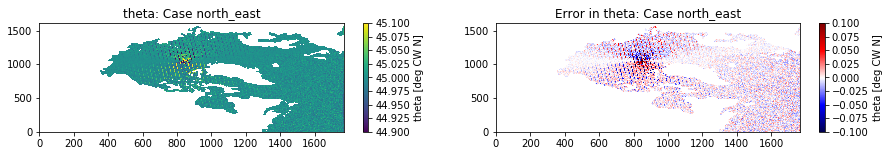

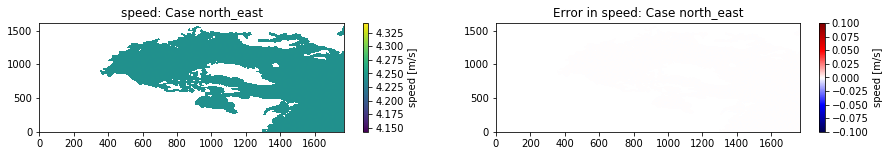

In [17]:
var_names=['U', 'V', 'theta', 'speed']
var_dicts = [us, vs, thetas, speeds]
varunits = ['m/s', 'm/s', 'deg CW N', 'm/s']
case='north_east'
xlim=[0,us[case].shape[-1]]
ylim=[0,us[case].shape[0]]
print('Evaluating error for Case {}'.format(case))
for var_name, var_dict, var_unit in zip(var_names, var_dicts, varunits):
    print('Error for {}'.format(var_name))
    var=var_dict[case]
    nominal_value=cases[case][var_name]
    print_mean_min_max_error(var, var_name, var_unit, nominal_value)
    plot_variable(var, var_name, var_unit, nominal_value, case,xlim=xlim,ylim=ylim)

# Conclusions
* Essentially no error in speed for all datasets.

### GIOPS
* Largest errors are in GIOPS. Although not apparent in the plots, the large errors are concentrated along the upper boundary. Again, I suspect this is related to mistreatment of the north fold.

### RIOPS native
* I'm very pleased with RIOPS on the native grid! All errors are very small. Again, this suggests mistreatment of the northfold in GIOPS because RIOPS has no northfold.

### RIOPS user
* RIOPS user errors are in the max/min sense smaller than GIOPS, but they are more spread out and very apparent in plots of bearing. I think this is because it is more difficult to define a rotation angle exactly at a grid corner (for example, should I look at the point to the left or to the right of the grid corner?). Since GIOPS/RIOPS native use the T,U and V information the angle can be defined exactly at the grid centre. 